In [58]:
import numpy as np
from utils.vehicle_simulation import Vehicle, Simulation, plot_car
import utils.cubic_spline_planner as cubic_spline_planner
from scipy.stats import multivariate_normal, multivariate_t, gamma
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from matplotlib import animation
from os.path import exists
import pickle

In [35]:
import numpy as np
from scipy.stats import multivariate_normal, multivariate_t

# Covariance matrix
cov_matrix = np.array([[2, 1], [1, 2]])

# Parameters for multivariate_normal
mean = [0, 0]
normal_dist = multivariate_normal(mean, cov_matrix)

# Parameters for multivariate_t
df = 10  # Adjust this parameter to control the spread
t_dist = multivariate_t(mean, cov_matrix, df)

# Generate samples from both distributions
num_samples = 1000
samples_normal = normal_dist.rvs(num_samples)
samples_t = t_dist.rvs(num_samples)

# Check variances
variance_normal = np.var(samples_normal, axis=0)
variance_t = np.var(samples_t, axis=0)

print("Variance of multivariate_normal:", variance_normal)
print("Variance of multivariate_t:", variance_t)


Variance of multivariate_normal: [1.93849538 1.92383589]
Variance of multivariate_t: [2.60261305 2.66269909]


In [39]:
class MPCTrajectory:
    """Trajectory class using Model Predictive Control to generate a trajectory for the vehicle."""    
    
    def __init__(self, x_points, y_points, line_segments, noise_dist = 'mvn', r1 = 1, r2 = 1, sp_reduction = True, savepath=None):

        self.x_points = x_points
        self.y_points = y_points

        self.line_segments = line_segments

        self.noise_dist = noise_dist
        
        self.r1 = r1
        self.r2 = r2
        
        self._states = None
        self._measurements = None


        self.states_hist = None
        self.controls_hist = None
                
        self.R = np.array([[self.r1, 0],
                        [0, self.r2]])
        
        self.sp_reduction = sp_reduction
        self.savepath = savepath

    @property
    def states(self):
        if self._states is None:
            if self.savepath and exists(self.savepath):
                # Load states, states_hist, controls_hist
                with open(self.savepath, 'rb') as file:
                    tmp = pickle.load(file)
                    
                self._states = tmp['states']
                self.states_hist = tmp['states_hist']
                self.controls_hist = tmp['controls_hist']
                
            else:
                self._states = self._calculate_states()
                if self.savepath:
                    # Pickle save states, states_hist, controls_hist
                    tmp = {'states': self._states, 'states_hist': self.states_hist, 'controls_hist': self.controls_hist}
                    with open(self.savepath, 'wb') as file:
                        pickle.dump(tmp, file)
                    
        return self._states

    @property
    def measurements(self):
        if self._measurements is None:
            self._calculate_measurements()
        return self._measurements
    
    # A function to further reduce the speed of the car in the corners
    # This is done by reducing the speed in the corners by a factor of 1.5
    # The method is pretty crude, based on testing and visual inspection, but it works
    def speed_reduction(self, cyaw, sp):
        speed_reduction = np.diff(cyaw)
        speed_reduction = np.concatenate([speed_reduction[int(len(speed_reduction)*0.05):],
                                        np.linspace(speed_reduction[-1], 0, int(len(speed_reduction)*0.05))])
        speed_reduction = np.convolve(speed_reduction, np.ones(len(sp) // 5)/(len(sp) // 5), mode='same')
        speed_reduction = ((1.5*np.max(np.abs(speed_reduction)) - np.abs(speed_reduction)) / (1.5*np.max(np.abs(speed_reduction))))
        speed_reduction = np.clip(speed_reduction, 0, 1)
        tmp = np.concatenate([np.ones(int(len(speed_reduction)*0.95)+1), np.linspace(1, 0, int(len(speed_reduction)*0.05))])
        tmp = tmp[:len(speed_reduction)]

        speed_reduction *= tmp
        
        sp_new = sp
        sp_new[:-1] *= speed_reduction
        
        return sp_new

    def _calculate_states(self):
        cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(self.x_points, self.y_points, ds=0.1)
        cyaw = np.abs(cyaw)
        
        initial_state = Vehicle(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)
        dl = 1.0
                
        simulation = Simulation(initial_state, goal_speed=0.5, target_speed=3, max_time = 1000)
        
        # Speed profile
        sp = np.abs(simulation.calc_speed_profile(cx, cy, cyaw))
        if self.sp_reduction:
            print("hello")
            sp = self.speed_reduction(cyaw, sp)
        
        # Simulation
        self.states_hist, self.controls_hist = simulation.simulate(cx, cy, cyaw, ck, dl, sp=sp)

        # Get simulation states
        x, y, v, yaw = self.states_hist['x'], self.states_hist['y'], self.states_hist['v'], self.states_hist['yaw']        

        # Calculate dx and dy
        dx = np.empty_like(x)
        dy = np.empty_like(y)
        for i in range(len(x)):
            dx[i] = v[i] * np.cos(yaw[i]) * initial_state.dt
            dy[i] = v[i] * np.sin(yaw[i]) * initial_state.dt

        return np.c_[x, y, dx, dy]

    # Measurement transition function
    def h(self, x):
        H = np.array([[1, 0, 0, 0],
                        [0, 1, 0, 0]])
        
        if x.ndim == 1:
            x = x.reshape(1, -1)     
            out = np.dot(x, H.T) + np.array([1.0 * np.sin(x[:, 1]), -1.0 * np.cos(x[:, 0])]).T
            out = out.flatten()
            
        else:
            out = np.dot(x, H.T) + np.array([1.0 * np.sin(x[:, 1]), -1.0 * np.cos(x[:, 0])]).T
        
        return out
    
    # Calculate measurements by passing states through h(x) and adding gaussian noise
    def _calculate_measurements(self):

        if self.noise_dist is 'mvn':
            r = multivariate_normal([0, 0], self.R).rvs(len(self._states)) 
        elif self.noise_dist is 'mvt':
            r = multivariate_t([0, 0], self.R, df=10).rvs(len(self._states))
        else:
            raise ValueError('noise_dist must be "mvn" or "mvt"')
              
        self._measurements = self.h(self._states) + r 

    def get_data(self):
        return self.states.copy(), self.measurements.copy()
    
    # Find the bounding box of the track for plotting
    def get_bounding_box(self):
        min_x, max_x = np.inf, -np.inf
        min_y, max_y = np.inf, -np.inf
        
        for line_segment in self.line_segments:
            min_x = np.min([min_x, np.min(line_segment[:, 0])])
            max_x = np.max([max_x, np.max(line_segment[:, 0])])
            min_y = np.min([min_y, np.min(line_segment[:, 1])])
            max_y = np.max([max_y, np.max(line_segment[:, 1])])

        min_x = np.min([min_x, np.min(self.x_points), np.min(self.states[:, 0]), np.min(self.measurements[:, 0])])
        max_x = np.max([max_x, np.max(self.x_points), np.max(self.states[:, 0]), np.max(self.measurements[:, 0])])
        min_y = np.min([min_y, np.min(self.y_points), np.min(self.states[:, 1]), np.min(self.measurements[:, 1])])
        max_y = np.max([max_y, np.max(self.y_points), np.max(self.states[:, 1]), np.max(self.measurements[:, 1])])
        
        return min_x, max_x, min_y, max_y
    
    def plot(self):
        min_x, max_x, min_y, max_y = self.get_bounding_box()      
        ratio = (max_x - min_x + 6) / (max_y - min_y + 6)        
        fig, ax = plt.subplots(1, 1, figsize=(ratio*4, 4))
        
        ax.plot(self.measurements[:, 0], self.measurements[:, 1], 'o', label='Measurements', markersize=3)
        ax.plot(self.x_points, self.y_points, 'x', label='Waypoints', markersize=10)
        ax.plot(self.states[:, 0], self.states[:, 1], label='Trajectory', linewidth=2)
        
        for line_segment in self.line_segments:
            ax.plot(line_segment[:, 0], line_segment[:, 1], 'k-', label='Boundaries', linewidth=1)
            

        ax.set_xlim(min_x - 3, max_x + 3)
        ax.set_ylim(min_y - 3, max_y + 3)
        ax.set_aspect('equal')

        ax.legend()

        plt.show()

    def animate(self, filename='animation'):
        min_x, max_x, min_y, max_y = self.get_bounding_box()      
        ratio = (max_x - min_x + 6) / (max_y - min_y + 6)        
        fig, ax = plt.subplots(1, 1, figsize=(ratio*4, 4))
        
        target_inds = self.controls_hist['target_inds'] 
        t = self.states_hist['t']
        v = self.states_hist['v']
        yaw = self.states_hist['yaw']
        d = self.controls_hist['d']

        def aux_animate(i):
            ax.cla()
            ax.plot(self.x_points, self.y_points, "kx", markersize=10)
            ax.plot(self.states[:i, 0], self.states[:i, 1], "-r", label="trajectory")
            ax.plot(self.measurements[:i, 0], self.measurements[:i, 1], 'bx', markersize=3, label="measurements")

            plot_car(ax, self.states[i, 0], self.states[i, 1], yaw[i], steer=d[i])

            for line_segment in self.line_segments:
                ax.plot(line_segment[:, 0], line_segment[:, 1], 'k-', label='Boundaries', linewidth=1)
            
            ax.set_title("Time [s]:" + str(round(t[i], 2)) + ", speed [km/h]:" + str(round(v[i] * 3.6, 2)))
            
            ax.grid(True)
            ax.set_xlim(min_x - 3, max_x + 3)
            ax.set_ylim(min_y - 3, max_y + 3)
            ax.set_aspect('equal')

        ani = animation.FuncAnimation(fig, aux_animate, frames=len(t), repeat=False)

        # Save animation with progress bar
        with tqdm(total=len(t)) as pbar:
            ani.save(f'{filename}.gif', writer='Pillow', fps=25, progress_callback=lambda i, n: pbar.update())
            
        plt.close()


def track_example1(seed=None):
    
    if seed:
        np.random.seed(seed)

    line_segments = [np.array([(1,1), (1,5), (40,5), (40,20), (45,20), (45,1), (1,1)])]

    x1 = np.linspace(5, 43, 6)
    x2 = np.repeat(42.5, 3) + np.random.normal(0, 0.75, 3)
    x2 = np.clip(x2, 41, 44)

    y1 = np.repeat(3, 6) + np.random.normal(0, 0.75, 6)
    y1 = np.clip(y1, 2, 4)

    y2 = np.linspace(7.5, 17.5, 3)

    x_coords = np.r_[2, x1, x2, 42.5]
    y_coords = np.r_[3, y1, y2, 19]

    return x_coords, y_coords, line_segments

def track_example2():

    line_segments = [np.array([(0, 0), (60, 0), (70, -2.5), (82.5, -2.5), (82.5, 8.5), (70, 8.5), (60, 6), (0, 6), (0, 3.5), (75, 3.5), (75, 2.5), (0, 2.5), (0, 0)])]
    x_coords_1 = np.array([4, 20, 50, 55, 60, 65, 70, 75, 80])
    x_coords_2 = x_coords_1[::-1]
    y_coords_1 = np.concatenate([np.repeat(1.25, 6), [0, -1.0, 1.75]])
    y_coords_2 = np.concatenate([[4.0, 7.0, 6.0], np.repeat(4.75, 6)])

    x_coords = np.concatenate([x_coords_1, x_coords_2])
    y_coords = np.concatenate([y_coords_1, y_coords_2])
    
    return x_coords, y_coords, line_segments

def track_example3(seed=None):
    
    if seed:
        np.random.seed(seed)

    line_segments = [np.array([(0,0), (0,5), (17.5, 5), (17.5, 10), (32.5, 10), (32.5, 5), (50,5), (50,0), (27.5,0), (27.5, 5), (22.5, 5), (22.5, 0), (0,0)])]

    x = np.linspace(2, 48, 6)

    y = np.repeat(2.5, 6) + np.random.normal(0, 0.25, 6)
    y = np.clip(y, 1, 4)

    x_coords = x
    y_coords = y

    return x_coords, y_coords, line_segments

In [41]:
x_coords, y_coords, line_segments = track_example1()

trajectory = MPCTrajectory(x_coords, y_coords, line_segments, noise_dist='mvt')

hello


MPC: 0it [00:00, ?it/s]

Goal


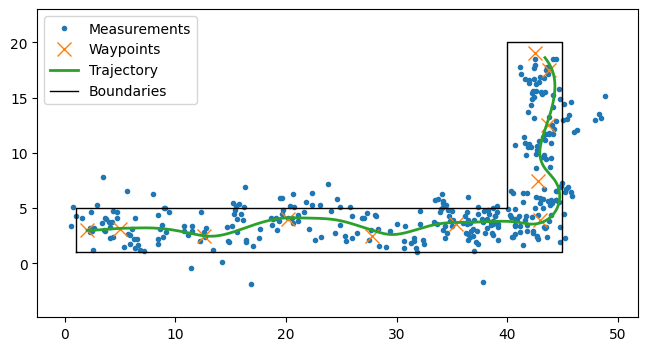

In [42]:
trajectory.plot()